## Importing Data

In [1]:
import pandas as pd
import keras
from keras import models
from keras.layers import Embedding, Dense, Flatten
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statistics

import warnings
warnings.filterwarnings('ignore')

train_ratio = 0.8
val_ratio = 1-train_ratio

# Trainng Samples loaded from Github Repo
data_file_path = 'https://raw.githubusercontent.com/usef-kh/HousePriceEstimation/master/Data/train.csv'
data_df = pd.read_csv(data_file_path)

# Testing Samples loaded from Github Repo
test_file_path = 'https://raw.githubusercontent.com/usef-kh/HousePriceEstimation/master/Data/test.csv'
test_df = pd.read_csv(test_file_path)

#Sepertaing training samples from labels 
lables_df = data_df.iloc[:, -1]
samples_df = data_df.iloc[:, 0:-1]

#normlizing training labels
y_train_df = lables_df[0:1165]
y_val_df = lables_df[1165:1461]

y_mean = statistics.mean(y_train_df)
y_std = statistics.stdev(y_train_df)
y_train_df = (y_train_df - y_mean) / y_std


#Concatenating dataframs
frames = [samples_df,test_df]
df = pd.concat(frames, keys=['train', 'test'],sort=False)

df.astype({'Id': 'int32'}).dtypes



print('Training size:' + str(samples_df.shape))
print('Testing size:' + str(test_df.shape))
print('Total size:' + str(df.shape))

print('-------------')
print('Y_train: ' + str(y_train_df.shape))
print('Y_val: ' + str(y_val_df.shape))
print('Y_total: ' + str(y_val_df.shape[0] + y_train_df.shape[0] ))


Using TensorFlow backend.


Training size:(1460, 80)
Testing size:(1459, 80)
Total size:(2919, 80)
-------------
Y_train: (1165,)
Y_val: (295,)
Y_total: 1460


## Processing Boolean Features


In [2]:
df_bool = df['CentralAir']
df_bool.fillna(0, inplace=True)

df_bool[df_bool == 'Y'] = 1
df_bool[df_bool == 'N'] = 0

df_bool.shape

(2919,)

## Processing Numeric Features


In [3]:
df_numeric = df[['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']]
df_numeric.fillna(0, inplace=True)

df_numeric.shape

(2919, 28)

## Processing Time Features


In [4]:
df_time = df[['YearBuilt','YearRemodAdd','YrSold']]

df_time.head(10)

reno_to_sale =  df_time['YrSold'].values - df_time['YearRemodAdd'].values
const_to_sale =  df_time['YrSold'].values - df_time['YearBuilt'].values

reno_to_sale[reno_to_sale < 0] = 0
const_to_sale[const_to_sale < 0] = 0



df_time.insert(2, "Renovation to Sale", reno_to_sale, True)
df_time.insert(2, "Construction to Sale", const_to_sale, True)

df_time = df_time[["Construction to Sale","Renovation to Sale"]]
df_time.shape

(2919, 2)

## Processing Cateorical Features

In [6]:
categories = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','GarageYrBlt','GarageFinish','PavedDrive','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']
df_cat = pd.DataFrame()
for cat in categories:
  
  df_catigorical = df[[cat]]

  #Determine Number of Catigories
  A = df_catigorical[cat].unique()
  df_catigorical['Encode'] = -1

  for i,a in enumerate(A):
    df_catigorical.loc[df_catigorical[cat] == a, 'Encode'] = int(i)

  df_catigorical_train = df_catigorical[0:1165]

  

  #Obtain Encodings
  embedding_size = 3

  model = models.Sequential()
  model.add(Embedding(input_dim = A.size, output_dim = embedding_size, input_length = 1, name="embedding"))
  model.add(Flatten())
  model.add(Dense(50, activation="relu"))
  model.add(Dense(15, activation="relu"))
  model.add(Dense(1))
  model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
  model.fit(x = df_catigorical_train['Encode'].as_matrix(), y=y_train_df.as_matrix() , epochs = 25, batch_size = 4, verbose = 0)

  layer = model.get_layer('embedding')
  output_embeddings = layer.get_weights()

  #Store Encodings
  output_embeddings_df = pd.DataFrame(output_embeddings[0])
  output_embeddings_df = output_embeddings_df.reset_index()
  output_embeddings_df.columns = ['MSSubClass', 'embedding_1', 'embedding_2', 'embedding_3']
  embed = output_embeddings_df.values[:,1:]


  #Set the Encoding Values
  cols = ['E1','E2','E3']

  df_catigorical[cols] = pd.DataFrame([-1*np.ones(len(cols))], index=df.index)

  for i,a in enumerate(A):
    df_catigorical.loc[df_catigorical['Encode'] == i, cols] = embed[i,:]

  df_cat = pd.concat([df_cat, df_catigorical[cols]], axis=1)
  print('Completed Category Number ' + str(categories.index(cat)+1) + ' out of ' + str(len(categories)))




Completed Category Number 1 out of 34
Completed Category Number 2 out of 34
Completed Category Number 3 out of 34
Completed Category Number 4 out of 34
Completed Category Number 5 out of 34
Completed Category Number 6 out of 34
Completed Category Number 7 out of 34
Completed Category Number 8 out of 34
Completed Category Number 9 out of 34
Completed Category Number 10 out of 34
Completed Category Number 11 out of 34
Completed Category Number 12 out of 34
Completed Category Number 13 out of 34
Completed Category Number 14 out of 34
Completed Category Number 15 out of 34
Completed Category Number 16 out of 34
Completed Category Number 17 out of 34
Completed Category Number 18 out of 34
Completed Category Number 19 out of 34
Completed Category Number 20 out of 34
Completed Category Number 21 out of 34
Completed Category Number 22 out of 34
Completed Category Number 23 out of 34
Completed Category Number 24 out of 34
Completed Category Number 25 out of 34
Completed Category Number 26 out

In [7]:
df_cat.shape

(2919, 102)

## Processing Ranking Features

In [32]:
df_ranking = df[['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','Fence']]
df_ranking.head(5)

OverallQual  OverallCond ExterQual  ... GarageCond PoolQC Fence
train 0            7            5        Gd  ...         TA    NaN   NaN
      1            6            8        TA  ...         TA    NaN   NaN
      2            7            5        Gd  ...         TA    NaN   NaN
      3            7            5        TA  ...         TA    NaN   NaN
      4            8            5        Gd  ...         TA    NaN   NaN

[5 rows x 16 columns]

In [47]:
ranks1 = ['NA' , 'No', 'Mn', 'Av' , 'Gd']

ranks2 = ['Po' , 'Fa', 'TA', 'Gd' , 'Ex']

ranks3 = ['NA' , 'Unf', 'LwQ', 'Rec' , 'BLQ', 'ALQ', 'GLQ']

ranks4 = ['NA' , 'MnWw', 'GdWo', 'MnPrv' , 'GdPrv']

#remove nan
df_ranking.fillna(0, inplace=True)

#do all other rankings
for i,rank in enumerate(ranks4):
  df_ranking.replace(rank,i, inplace = True)

#do the different ranking
for i,rank in enumerate(ranks1):
  df_ranking.replace(rank,i, inplace = True)
  
#do all other rankings
for i,rank in enumerate(ranks2):
  df_ranking.replace(rank,i, inplace = True)
  
#do all other rankings
for i,rank in enumerate(ranks3):
  df_ranking.replace(rank,i, inplace = True)
  

  
#fill NA with zero - from data description
df_ranking.replace('NA' , 0 , inplace = True)

df_ranking.shape


# Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor


(2919, 16)

## Training Network

In [48]:
from sklearn import preprocessing
import numpy as np


final_df = pd.concat([df_numeric,df_time,df_bool,df_cat,df_ranking], axis=1)
final_data = final_df.values

# cats = df_cat.values[:,1:]
x_train = final_data[0:1165]
x_val = final_data[1165:1460]
x_test = final_data[1460:]
# training = np.concatenate((df_values, cats), axis=1)

scaler = preprocessing.MinMaxScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

y_train = y_train_df.values
y_val = y_val_df.values


print('Training size:' + str(x_train.shape))
print('Validation size: ' + str(x_val.shape))
print('Testing size: ' + str(x_test.shape))
print('Total size: ' + str(x_train.shape[0] + x_val.shape[0] + x_test.shape[0] ))

print('-------------')
print('Y_train: ' + str(y_train_df.shape))
print('Y_val: ' + str(y_val_df.shape))
print('Y_total: ' + str(y_val_df.shape[0] + y_train_df.shape[0] ))

Training size:(1165, 149)
Validation size: (295, 149)
Testing size: (1459, 149)
Total size: 2919
-------------
Y_train: (1165,)
Y_val: (295,)
Y_total: 1460


In [49]:
from keras import models
from keras import layers


model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
          loss='mse',
          metrics=['mse'])

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 128)               19200     
_________________________________________________________________
dense_137 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_138 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_139 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_140 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_141 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_142 (Dense)            (None, 128)             

In [50]:
history = model.fit(x = x_train,
              y = y_train,
              validation_data=(x_val,y_val),
              epochs=50,
              batch_size=128,
              verbose=1)

# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)

Train on 1165 samples, validate on 295 samples
Epoch 1/50
1165/1165 [==============================] - 3s 2ms/step - loss: 0.8441 - mean_squared_error: 0.8441 - val_loss: 40002308755.5254 - val_mean_squared_error: 40002308755.5254
Epoch 2/50
1165/1165 [==============================] - 0s 58us/step - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 40002395854.5356 - val_mean_squared_error: 40002395854.5356
Epoch 3/50
1165/1165 [==============================] - 0s 56us/step - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 40002119339.8237 - val_mean_squared_error: 40002119339.8237
Epoch 4/50
1165/1165 [==============================] - 0s 56us/step - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 40002209840.5966 - val_mean_squared_error: 40002209840.5966
Epoch 5/50
1165/1165 [==============================] - 0s 54us/step - loss: 0.1660 - mean_squared_error: 0.1660 - val_loss: 40002387509.8034 - val_mean_squared_error: 40002387509.8034
Epoch 6/50
1165/1165 [=======

Minimum Validation Loss is:40002119339.82373
Epoch: 2


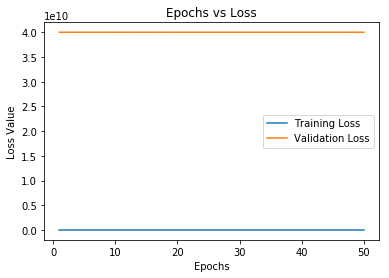

In [51]:
def loss_curve(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  x_axis     = range(1, len(history.history['loss'])+1)
  
  plt.figure()
  plt.plot(x_axis, train_loss, label="Training Loss")
  plt.plot(x_axis, val_loss, label="Validation Loss")
  plt.ylabel('Loss Value')
  plt.xlabel('Epochs')
  plt.title('Epochs vs Loss')
  plt.legend()
  print('Minimum Validation Loss is:' + str(min(val_loss)))
  print('Epoch: ' + str(val_loss.index(min(val_loss))))
  
loss_curve(history)

In [52]:
results = (model.predict(x_test)*y_std)+y_mean

print(results)

[[123653.3 ]
 [150910.19]
 [185523.62]
 ...
 [139900.88]
 [117808.86]
 [214947.94]]


In [0]:
pd.DataFrame(results).to_csv("file.csv")